In [1]:
# import libraries
import numpy as np
import os
import sklearn
import sklearn.neighbors
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import itertools
import time
import random
import load_data
#import VGG_CV as CV

# you can get warnings fter importing theano, that is fine.
# if you get errors, ask the TAs!
import lasagne
import theano
import lasagne.layers as L
from theano import tensor as T

Using TensorFlow backend.


In [2]:
data_dir = './input'# define here the directory where you have your data

In [3]:
# labels for the three classes in this classification problem.
# These are the same names used in folders for raw training data
cervixTypes = ["Type_1", "Type_2", "Type_3"]
n_classes = len(cervixTypes)
print('Classification problem with {} classes'.format(n_classes))

Classification problem with 3 classes


In [4]:
data, labels = load_data.load_train()

create new hdf5 file
Read train images
.('Cervix #', 1, ': ', 'Type_1', ', image # ', 1, ': ', '.DS_Store')
('Cervix #', 1, ': ', 'Type_1', ', image # ', 2, ': ', '0.jpg')
(3264, 2448, 3)
(400, 400, 3)
(3, 400, 400)
('Cervix #', 1, ': ', 'Type_1', ', image # ', 3, ': ', '10.jpg')
(4128, 3096, 3)
(400, 400, 3)
(3, 400, 400)
('Cervix #', 1, ': ', 'Type_1', ', image # ', 4, ': ', '1013.jpg')
(3264, 2448, 3)
(400, 400, 3)
(3, 400, 400)
('Cervix #', 1, ': ', 'Type_1', ', image # ', 5, ': ', '1014.jpg')
(4128, 3096, 3)
(400, 400, 3)
(3, 400, 400)
('Cervix #', 1, ': ', 'Type_1', ', image # ', 6, ': ', '1019.jpg')
(3264, 2448, 3)
(400, 400, 3)
(3, 400, 400)
('Cervix #', 1, ': ', 'Type_1', ', image # ', 7, ': ', '102.jpg')
(3264, 2448, 3)
(400, 400, 3)
(3, 400, 400)
('Cervix #', 1, ': ', 'Type_1', ', image # ', 8, ': ', '1023.jpg')
(4128, 3096, 3)
(400, 400, 3)
(3, 400, 400)
('Cervix #', 1, ': ', 'Type_1', ', image # ', 9, ': ', '1024.jpg')
(3264, 2448, 3)
(400, 400, 3)
(3, 400, 400)
('Cervix #

ValueError: I/O operation on closed file

In [9]:
labels.shape[0]

1480

In [5]:
samples_per_class = [249, 781, 450]

In [19]:
def split_training_validation_datasets(x, y, samples_per_class, val_percentage=0.3, val_balanced=True):
    """
    Derive a training and a validation datasets from a given dataset with
    data (x) and labels (y). By default, the validation set is 30% of the
    training set, and it has balanced samples across classes. When balancing,
    it takes the 30% of the class with less samples as reference.
    """
    n_cv_samples_per_class = int(np.amin(samples_per_class) * 0.3)
    
    mask = np.zeros(x.shape[0], dtype=bool)
    low = 0
    high = 0
     
    for c in samples_per_class:
        high = high + c
        ids_cv = np.random.choice(np.arange(low,high),n_cv_samples_per_class, replace = False)
        mask[ids_cv] = True
        low = low + c   
    
    x_train = x[~mask,:, :, :]
    y_train = y[~mask, :]

    x_validation = x[mask,:, :, :]
    y_validation = y[mask, :]
    
    return x_train, y_train, x_validation, y_validation


In [20]:
x_train, y_train, x_validation, y_validation = split_training_validation_datasets(data, labels, samples_per_class)
#mask = split_training_validation_datasets(data, labels, samples_per_class)

In [60]:
x_train = x_train.transpose((0,3,1,2))
x_validation = x_validation.transpose((0,3,1,2))

In [61]:
# shuffle training dataset
shuffle_mask = np.random.permutation(x_train.shape[0])
x_train = x_train[shuffle_mask]
y_train = y_train[shuffle_mask]

In [62]:
# input tensors for data and targets
input_var  = T.ftensor4('input')
target_var = T.dmatrix('targets')

In [63]:
# Task 1
data_size = x_train.shape
print data_size
print n_classes

(1258, 3, 400, 400)
3


In [88]:
# Build your network

# Define your network builder function. You can assume the (1, 3, 32, 32) input size.
#
def build_network(input_tensor):
    """
    Define the network layers.
    
    Args:
        input_tensor (theano.tensor.ftensor4): Input tensor.
    
    Returns:
        lasagne.layers.Layer: Output layer.
    """
    
    # Input layer.
    #
    # NOTE: The "None" value here IS NOT something you have to implement!
    # It is a way to indicate that the mini-batch size is undefined when
    # the network is build, because you may want to try with different
    # batch sizes. Using "None" keeps this option open.
    network = L.InputLayer(shape=(None, 3, 400, 400), input_var=input_tensor)
    
    # Hidden layers and the output layer.
    #
    # Your code. Hint: you can modify your network from the last assignment to use lasagne.layers.Conv2DLayer
    # (((W - F + 2P) / S) + 1)
    conv_l1 = L.Conv2DLayer(network, num_filters=10, filter_size=(7,7), stride=1, pad=0) #28
    
    maxpool_l1 = L.MaxPool2DLayer(conv_l1, pool_size=(2,2), stride=2, pad=0) #14
    
    conv_l2 = L.Conv2DLayer(maxpool_l1, num_filters=10, filter_size=(3,3), stride=1, pad=0) #10
    
    maxpool_l2 = L.MaxPool2DLayer(conv_l2, pool_size=(2,2), stride=2, pad=0) #5
    
    dense_l1 = L.DenseLayer(maxpool_l2, num_units=100,nonlinearity=lasagne.nonlinearities.sigmoid)
    
    network = L.DenseLayer(dense_l1, num_units=3,nonlinearity=lasagne.nonlinearities.softmax)
    
    # Return the built network.
    #
    return network

In [96]:
def training_function(network, input_tensor, target_tensor, learning_rate, use_l2_regularization=False, l2_lambda=0.0001):
    """
    Training function.
    
    Args:
        network (lasagne.layers.Layer): Output layer.
        input_tensor (theano.tensor.ftensor4): Input tensor.
        target_tensor (theano.tensor.ivector): Target tensor.
        
    Returns:
        function: Network update function. It accepts [input_tensor, target_tensor] tensors as input and outputs
           [loss, l2_loss, accuracy] values.
    """
    
    # Get the network output and calculate metrics.
    #
    network_output = L.get_output(network, input_tensor)
    l2_loss = lasagne.regularization.l2(network_output)
    loss = lasagne.objectives.categorical_crossentropy(network_output, target_tensor).mean()
    loss = loss + (l2_lambda * l2_loss)
    accuracy = T.mean(T.eq(T.argmax(network_output, axis=1), T.argmax(target_tensor, axis=1)), dtype=theano.config.floatX)

    # Get the network parameters and the update function.
    #
    network_params = L.get_all_params(network, trainable=True)
    weight_updates = lasagne.updates.sgd(loss, network_params, learning_rate)

    # Construct the training function.
    #
    #  return theano.function([input_tensor, target_tensor], [loss, l2_loss, accuracy], updates=weight_updates)
    return theano.function([input_tensor, target_tensor], [loss, accuracy], updates=weight_updates)

In [97]:
def validate_function(network, input_tensor, target_tensor):
    """
    Validation function.
    
    Args:
        network (lasagne.layers.Layer): Output layer.
        input_tensor (theano.tensor.ftensor4): Input tensor.
        target_tensor (theano.tensor.ivector): Target tensor.
        
    Returns:
        function: Network validation function. It accepts [input_tensor, target_tensor] tensors as input and outputs
           [loss, accuracy] values.
    """

    # Get the network output and calculate metrics.
    #
    network_output = L.get_output(network, input_tensor)
    loss = lasagne.objectives.categorical_crossentropy(network_output, target_tensor).mean()
    accuracy = T.mean(T.eq(T.argmax(network_output, axis=1), T.argmax(target_tensor, axis=1)), dtype=theano.config.floatX)
    
    # Construct the validation function.
    #
    return theano.function([input_tensor, target_tensor], [loss, accuracy])

In [98]:
def evaluate_function(network, input_tensor):
    """
    Evaluation function.
    
    Args:
        network (lasagne.layers.Layer): Output layer.
        input_tensor (theano.tensor.ftensor4): Input tensor.
        
    Returns:
        function: Network evaluation function. It accepts [input_tensor] tensor as input and outputs the network
           prediction [prediction].
    """
    
    # Get the network output and calculate metrics.
    #
    network_output = L.get_output(network, input_tensor)
    
    # Construct the evaluation function.
    #
    return theano.function([input_tensor], network_output)

In [99]:
def train_convnet(network,
                  train_x,
                  train_y,
                  validation_x,
                  validation_y,
                  n_epochs,
                  network_name,
                  training_fn,
                  validation_fn,
                  training_batch_size,
                  validation_batch_size,
                  plot_curves=True):
    """
    Train the given network.
    
    Args:
        network (lasagne.layers.Layer): Output layer.
        train_x (numpy.ndarray): Training images.
        train_y (numpy.ndarray): Training labels.
        validation_x (numpy.ndarray): Validation images.
        validation_y (numpy.ndarray): Validation labels.
        n_epochs (int): Number of epochs.
        network_name (str): Name used to identify experiment.
        training_fn (function): Training function.
        validation_fn (function): Validation function.
        training_batch_size (int): Training batch size.
        validation_batch_size (int): Validation batch size.
        plot_curves (bool): Plot curves flag.
    """
    
    n_mini_batch_training = (train_x.shape[0]/training_batch_size)
    
    # lists where we will be storing values during training, for visualization purposes
    tra_losses = []
    val_losses = []
    val_accs   = []
    
    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_val_acc = 0
    
    for epoch in xrange(n_epochs):
    
        st = time.time()

        # training
        cum_tra_loss = 0.0 # cumulative training loss
        for b in range(n_mini_batch_training):
            x_batch = train_x[b*training_batch_size:training_batch_size*(b+1)].astype(np.float32) # extract a mini-batch from x_train
            y_batch = train_y[b*training_batch_size:training_batch_size*(b+1)].astype(np.int32) # extract labels for the mini-batch
            mini_batch_loss, mini_batch_acc = training_fn(x_batch, y_batch)
            cum_tra_loss += mini_batch_loss

        # validation
        val_loss, val_acc = validation_fn(validation_x.astype(np.float32), validation_y.astype(np.int32))
        # if the accuracy improves, save the network parameters
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # save network
            params = lasagne.layers.get_all_param_values(network)
            np.savez('./'+network_name+'.npz', params=params)

        tra_loss = cum_tra_loss # final training loss for this epoch

        # add to lists
        tra_losses.append(tra_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        en = time.time()

        # plot learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, val_loss_plt, val_acc_plt], 
                   ['training loss', 'validation loss', 'validation accuracy'],
                   loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_val_acc))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [ ]:
# Define parameters
#
tra_batch_size = 64
val_batch_size = 18
n_epochs = 100
learning_rate = 0.1

network_name = 'network'

# Define the symbolic input X and the symbolic target y.
#
inputs = T.tensor4('X')
targets = T.dmatrix('y')

# Build the network.
#
network = build_network(input_tensor=inputs) # THIS FUNCTION MAY CHANGE IN FUTURE EXPERIMENTS!

# Define functions.
#
train_network = training_function(network=network, input_tensor=inputs, target_tensor=targets, learning_rate=learning_rate)
validate_network = validate_function(network=network, input_tensor=inputs, target_tensor=targets)

# Train the network.
#
train_convnet(network,
              x_train,
              y_train,
              x_validation,
              y_validation,
              n_epochs,
              network_name,
              training_fn=train_network,
              validation_fn=validate_network,
              training_batch_size=tra_batch_size,
              validation_batch_size=val_batch_size,
              plot_curves=True)

In [81]:
# Task 1
# get the network
network = build_neural_network(data_size, n_classes)

# get the prediction during training
prediction = lasagne.layers.get_output(network, input_var)

# define the (data) loss
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

In [82]:
# learning rate
lr = 0.1

In [83]:
# Task 1
# extract the parameters we want to optimize
params = lasagne.layers.get_all_params(network) # all parameters made "trainable"

# indicate that we will train using SGD
updates = lasagne.updates.sgd(loss,params, lr)

In [84]:
# Task 1
# get the prediction on the validation set during training
val_prediction = lasagne.layers.get_output(network, input_var, deterministic=True)
val_loss = lasagne.objectives.categorical_crossentropy(val_prediction, target_var)
val_loss = val_loss.mean()

# compute the (mean) accuracy
val_acc  = T.mean(T.eq(T.argmax(val_prediction, axis=1), T.argmax(target_var, axis=1)), dtype=theano.config.floatX)

In [85]:
# Task 1
train_fn  = theano.function([input_var, target_var], loss, updates=updates, name='train')
val_fn    = theano.function([input_var, target_var], [val_loss, val_acc]  , name='validation')
get_preds = theano.function([input_var]            , val_prediction       , name='get_preds')

In [86]:
# Task 1
val_loss, val_acc = val_fn(x_validation.astype(np.float32), y_validation.astype(np.float32))
print ('Initial validation accuracy = {:.2f}%'.format(100.*val_acc))

Initial validation accuracy = 33.33%


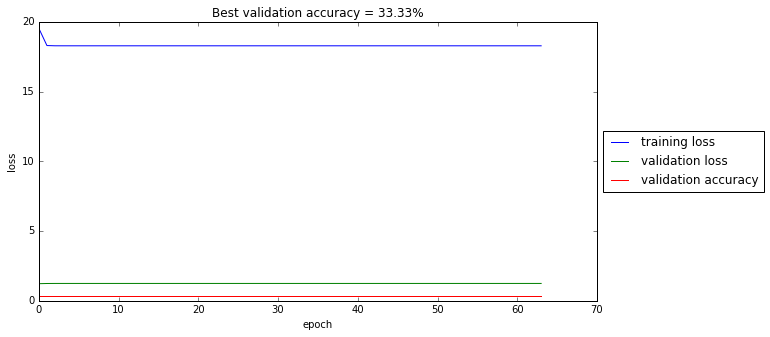

KeyboardInterrupt: 

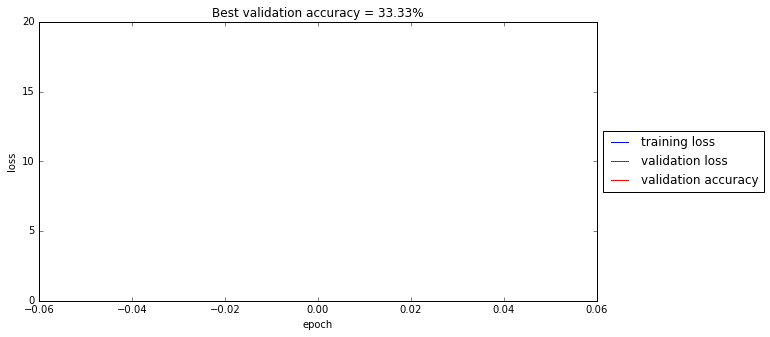

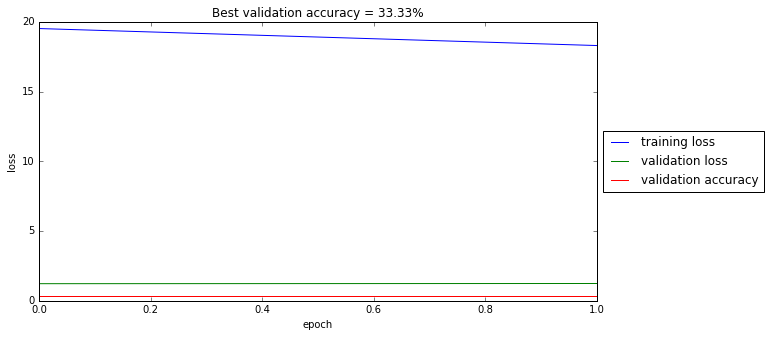

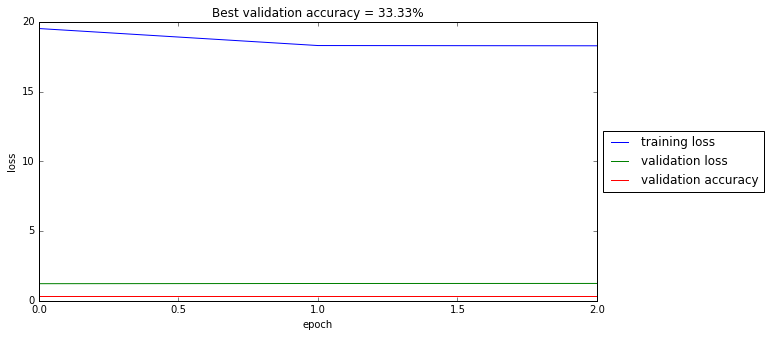

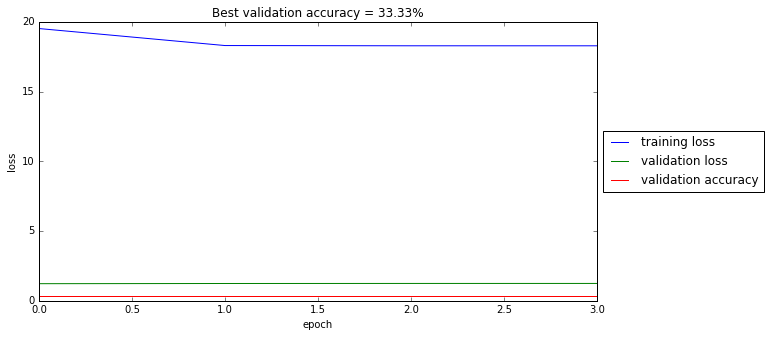

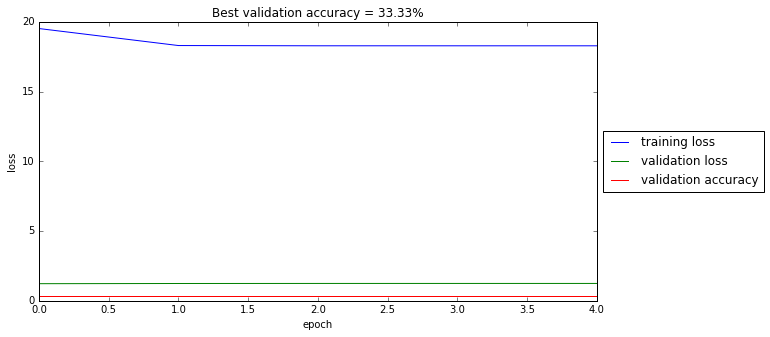

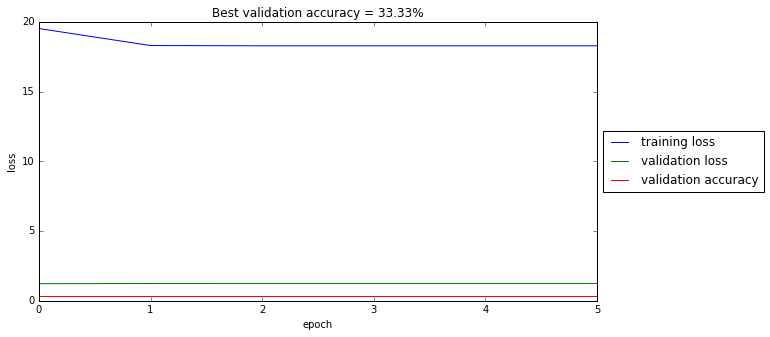

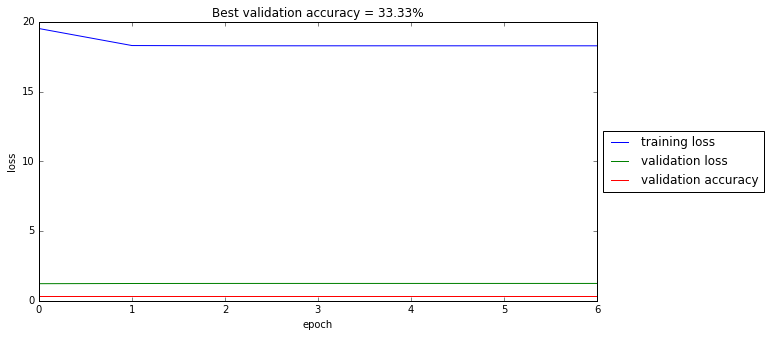

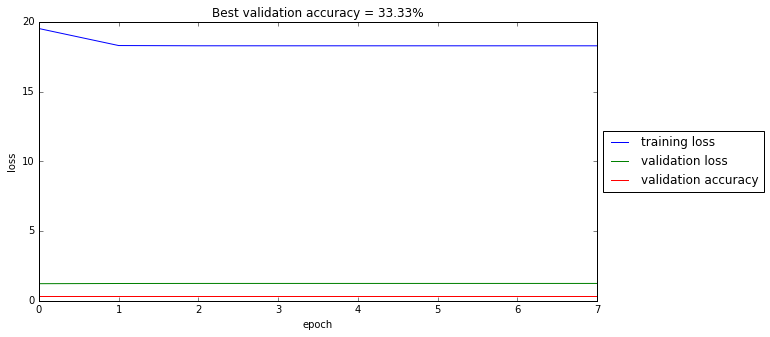

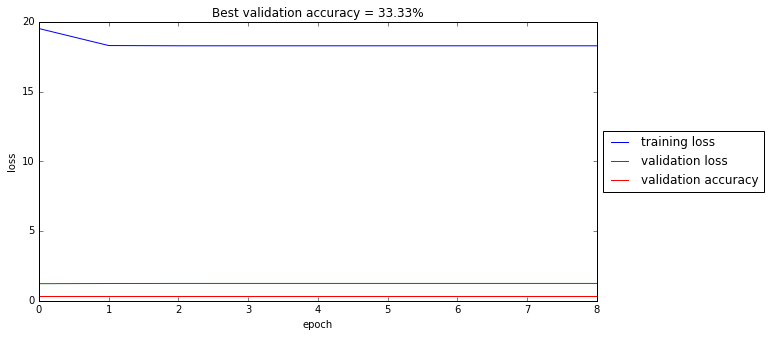

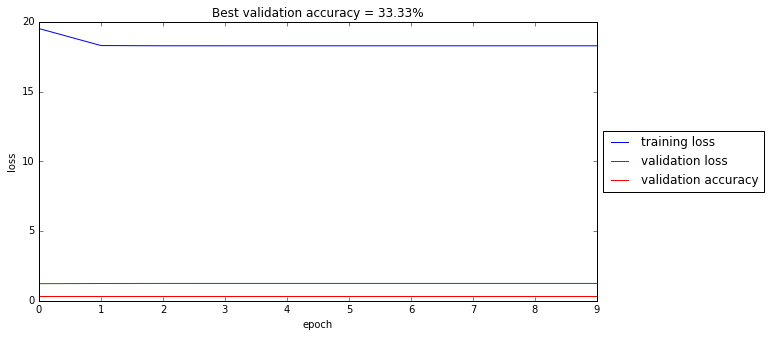

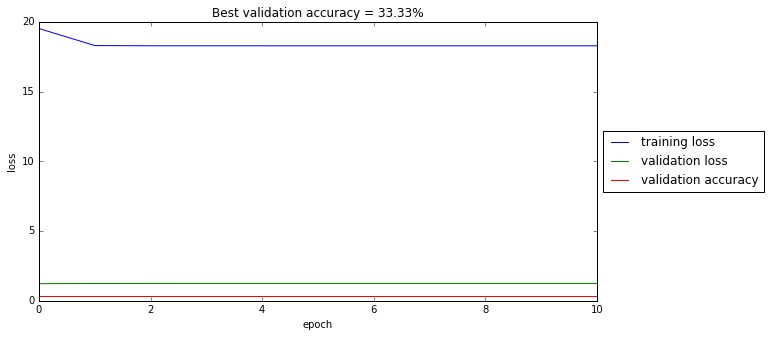

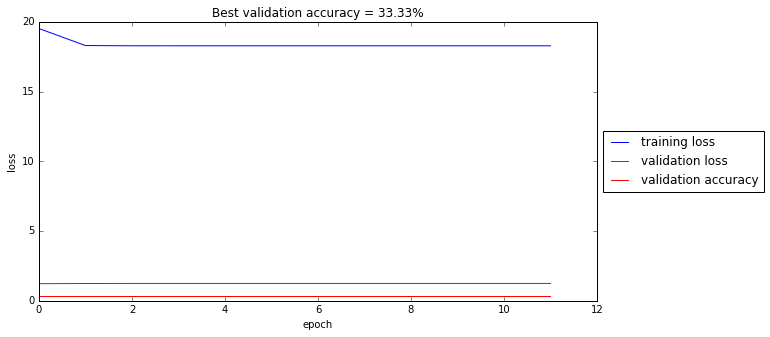

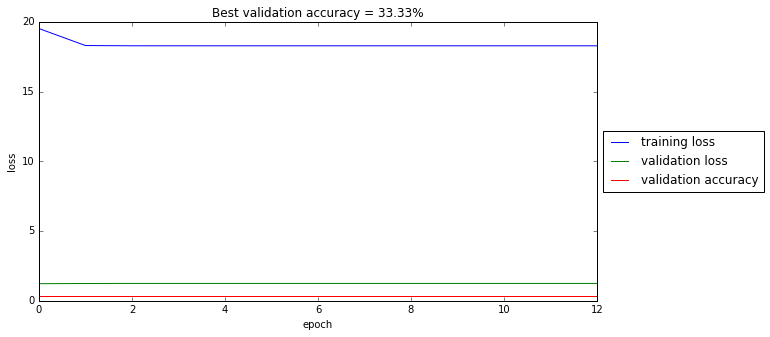

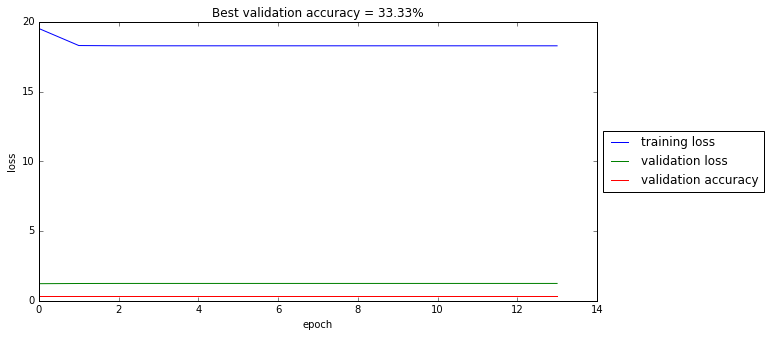

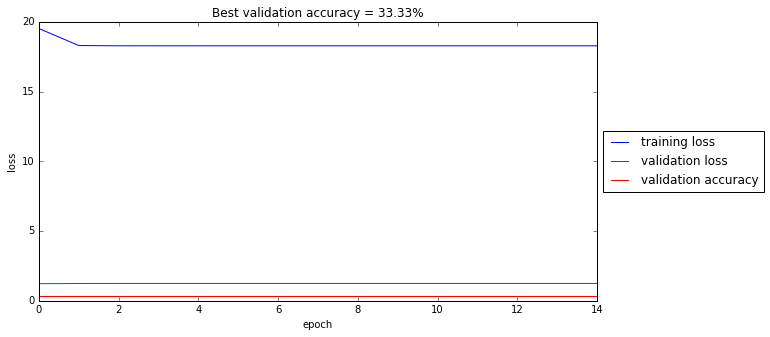

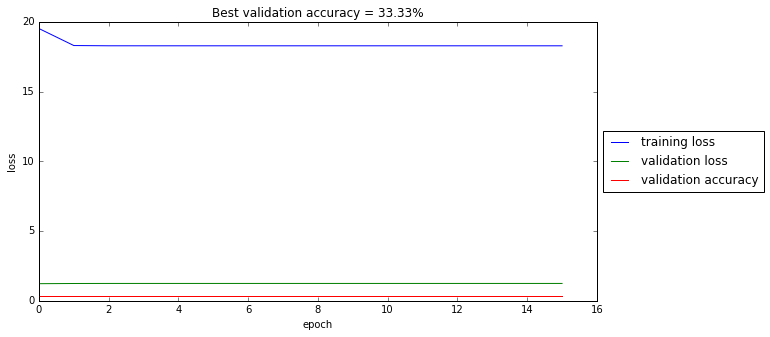

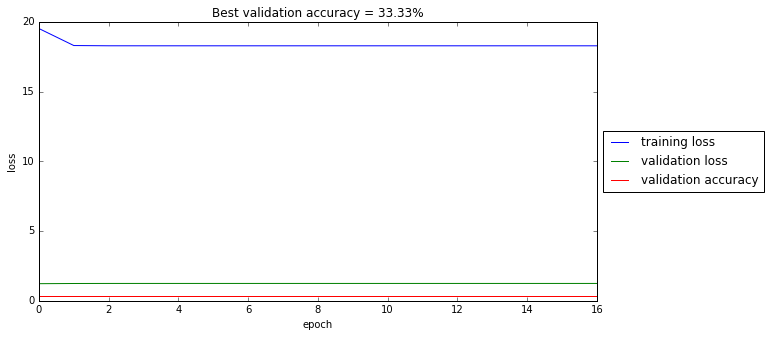

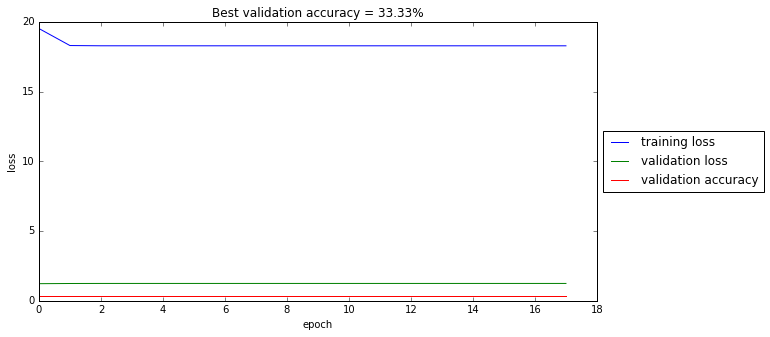

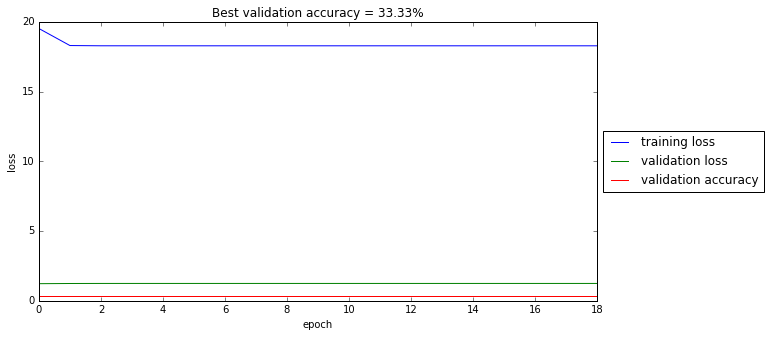

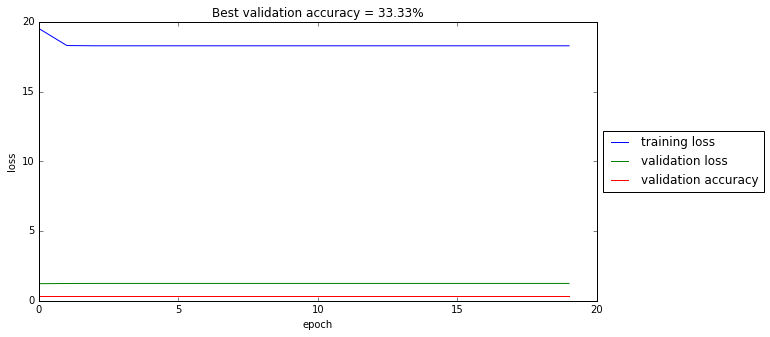

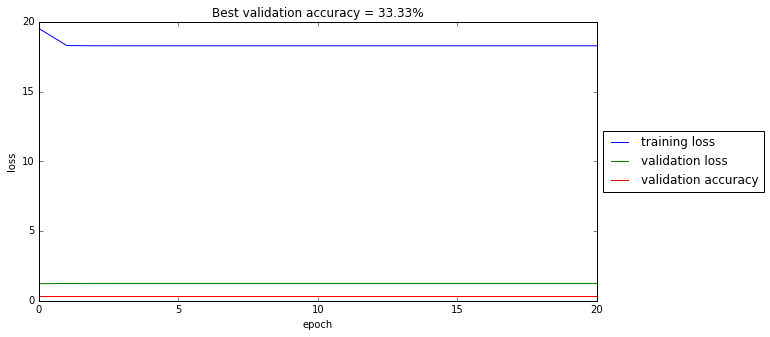

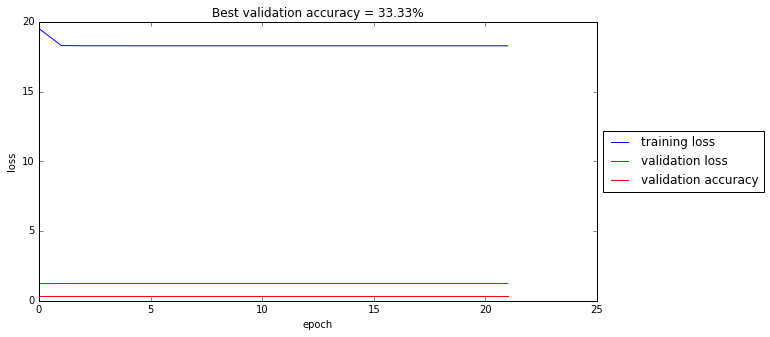

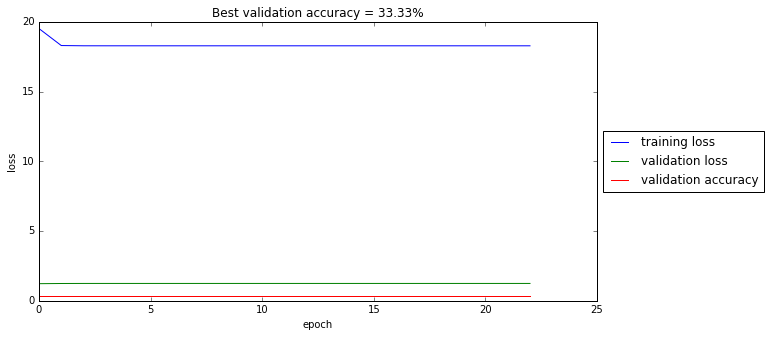

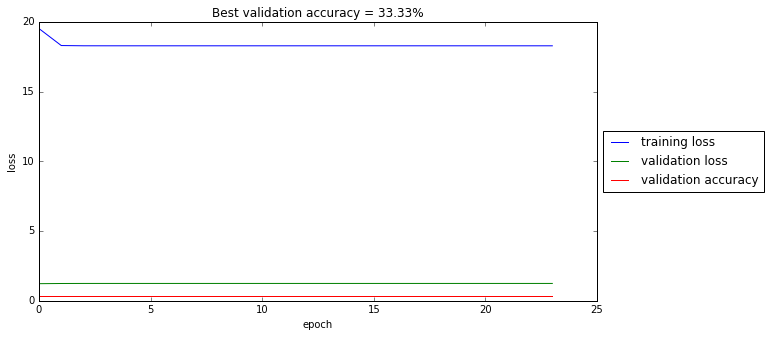

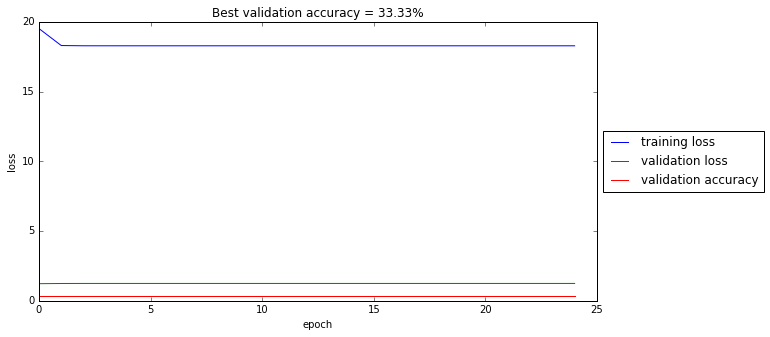

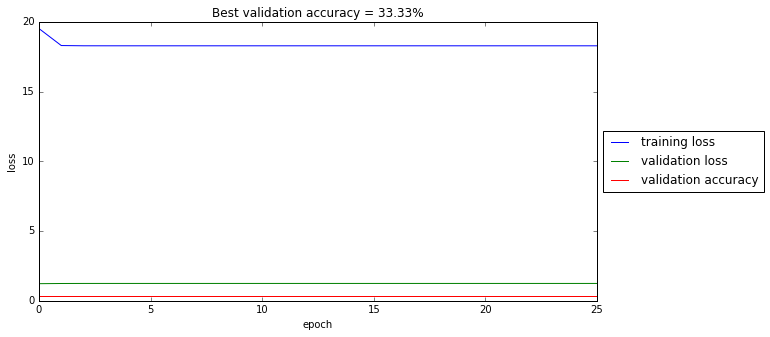

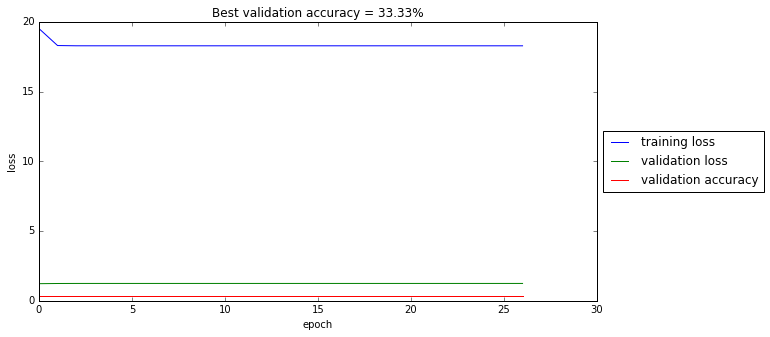

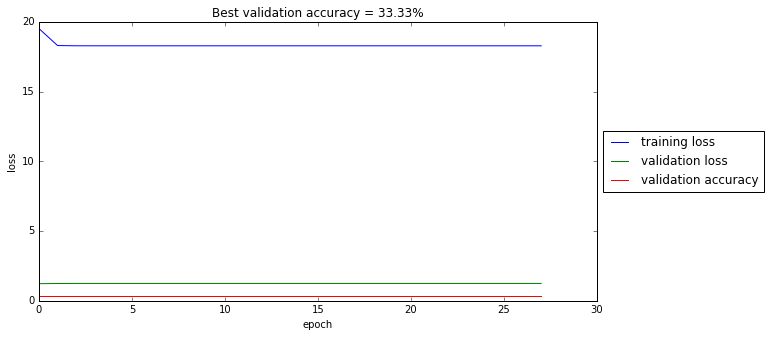

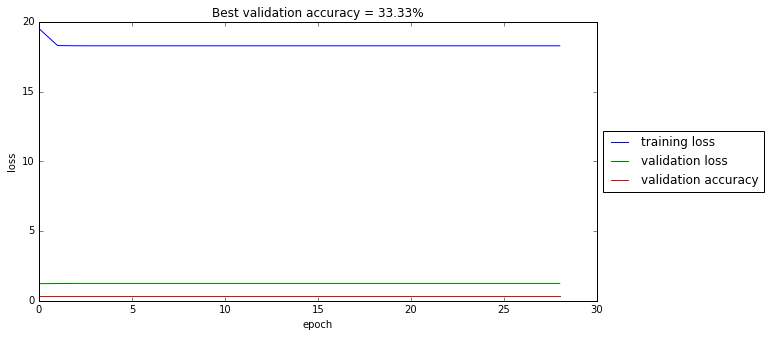

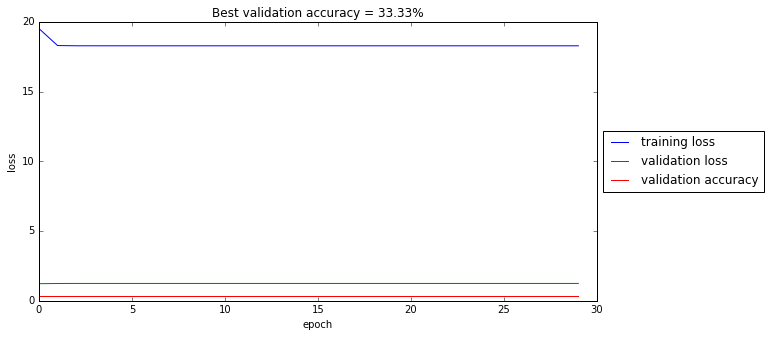

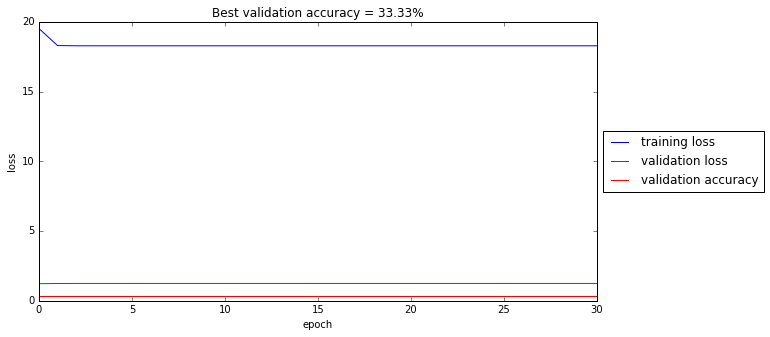

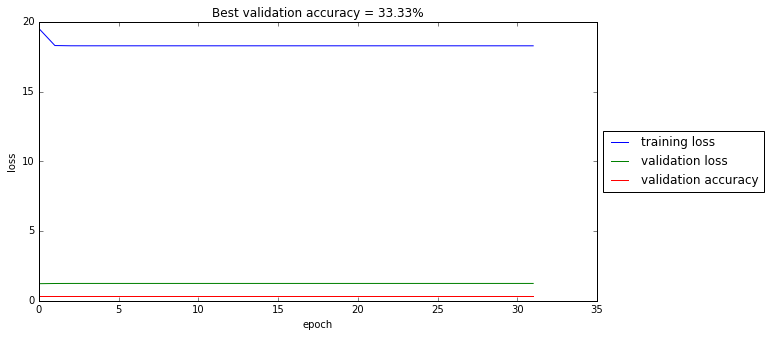

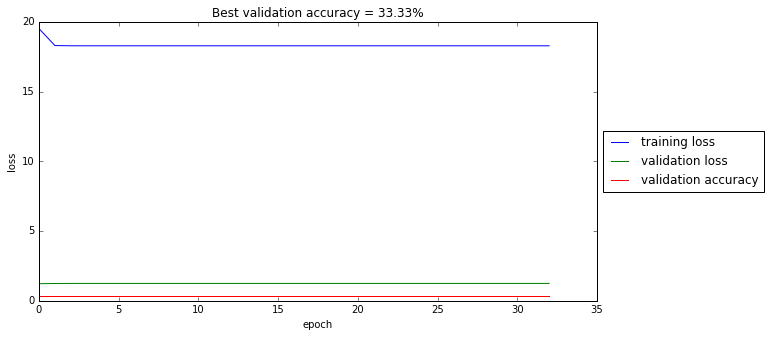

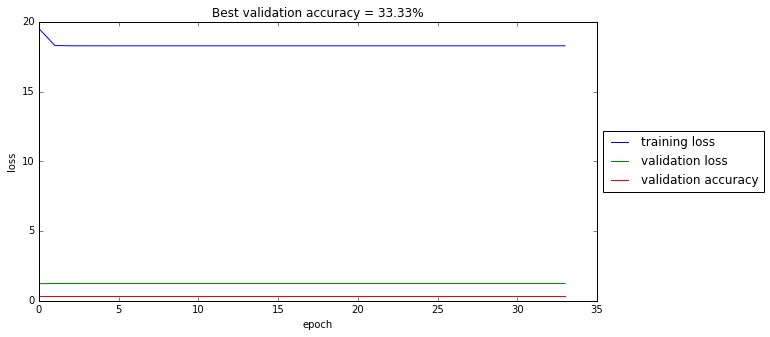

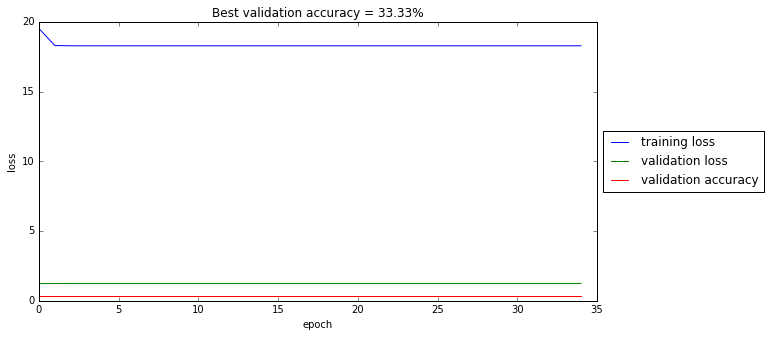

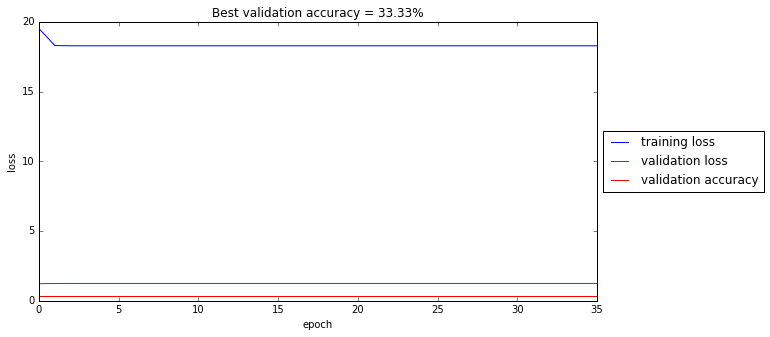

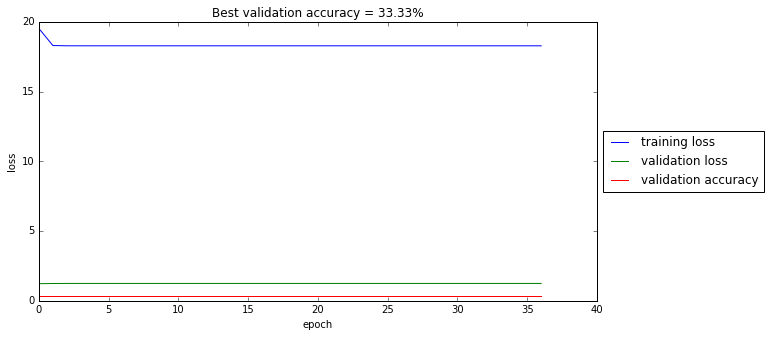

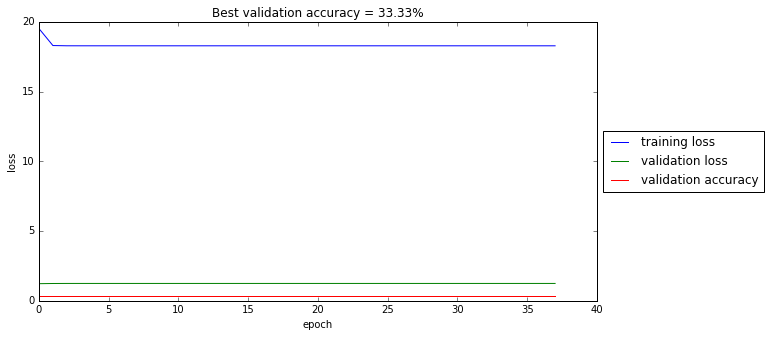

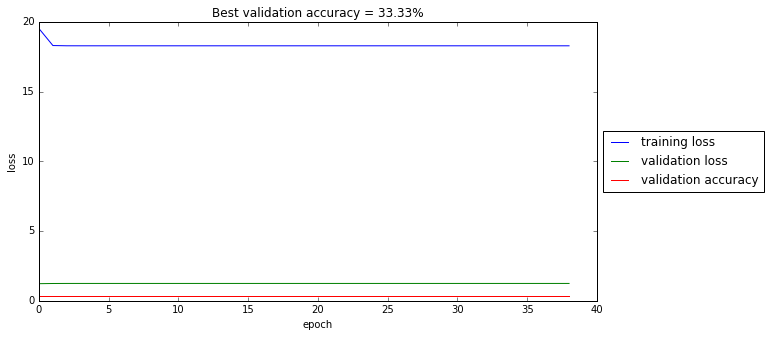

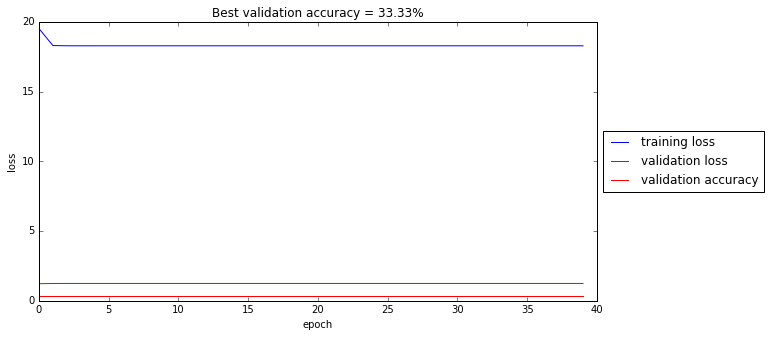

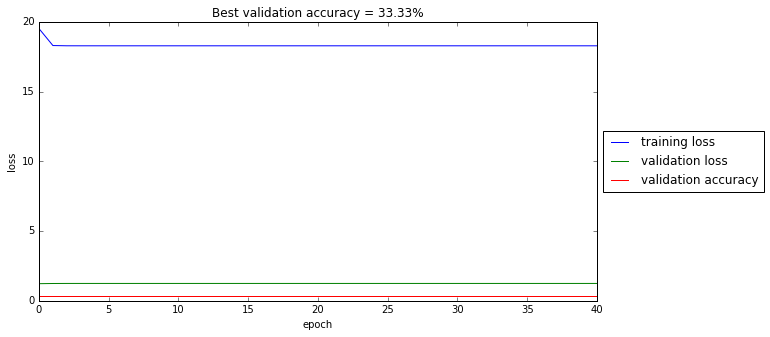

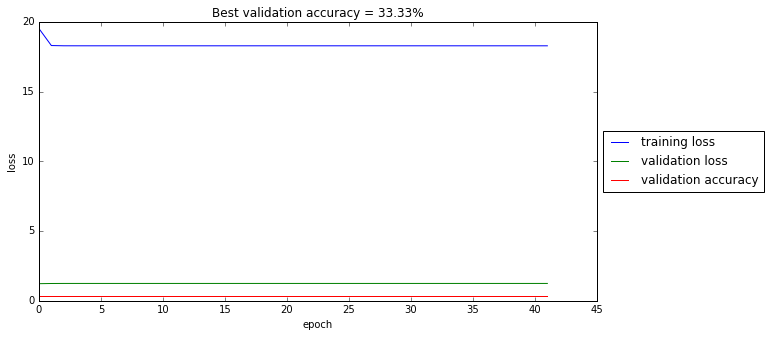

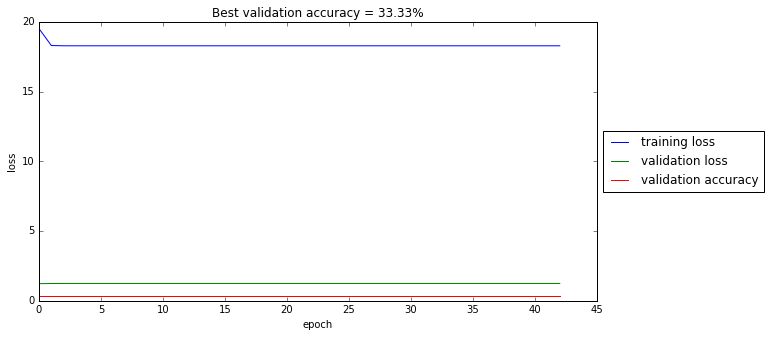

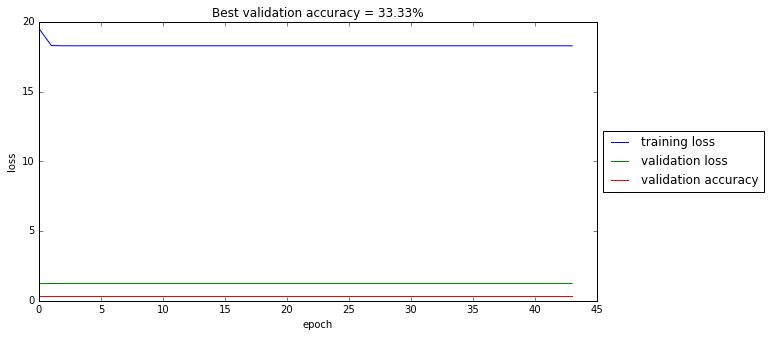

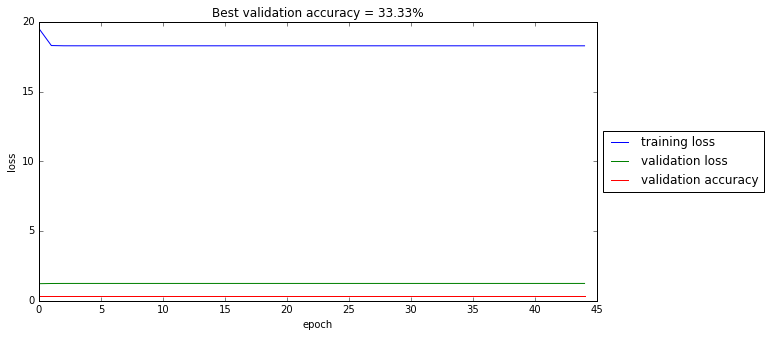

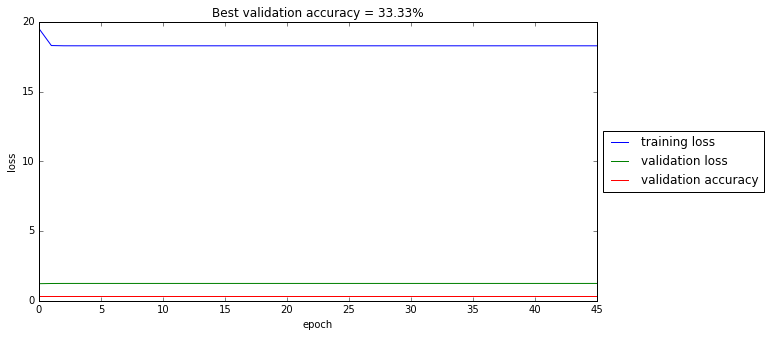

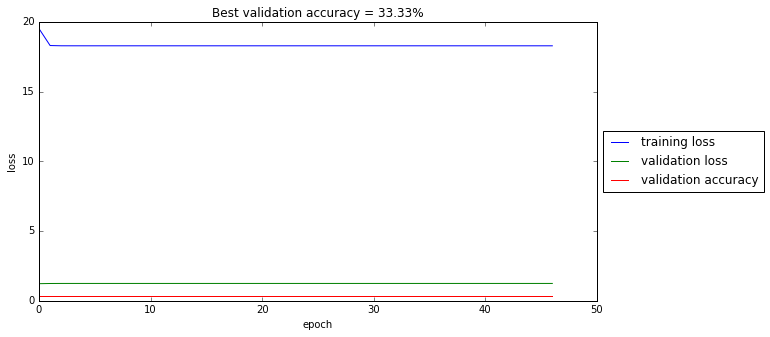

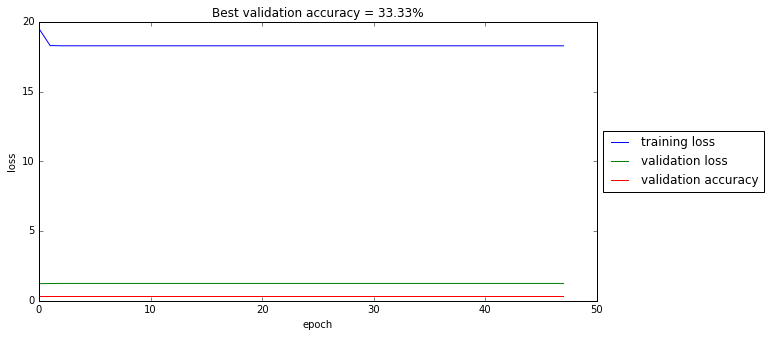

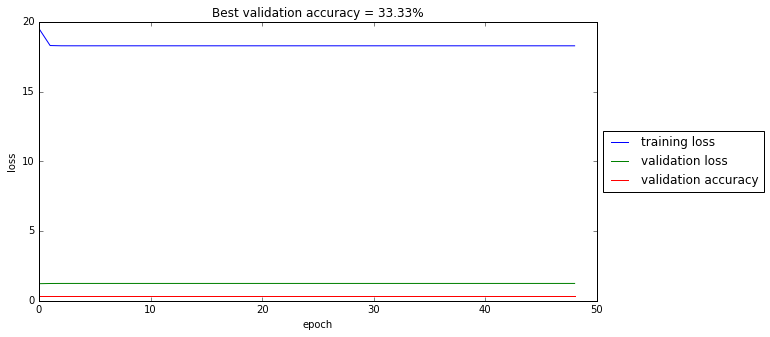

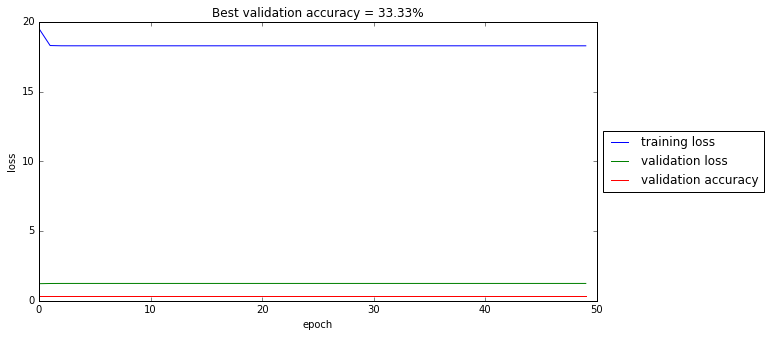

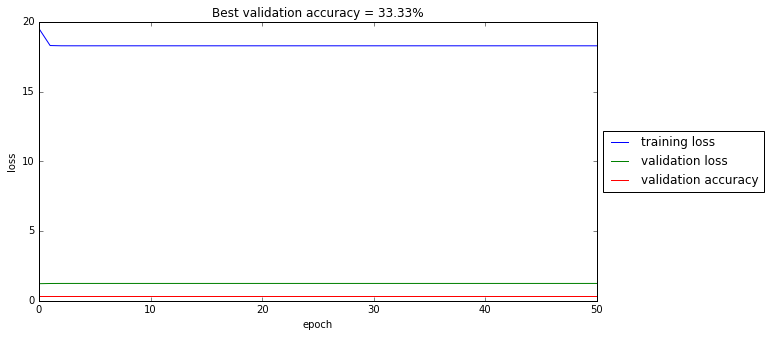

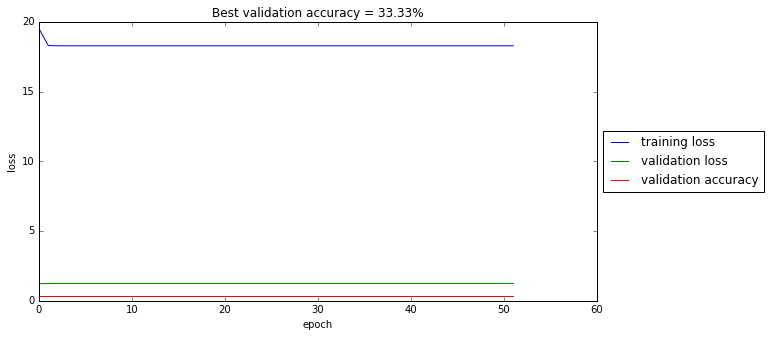

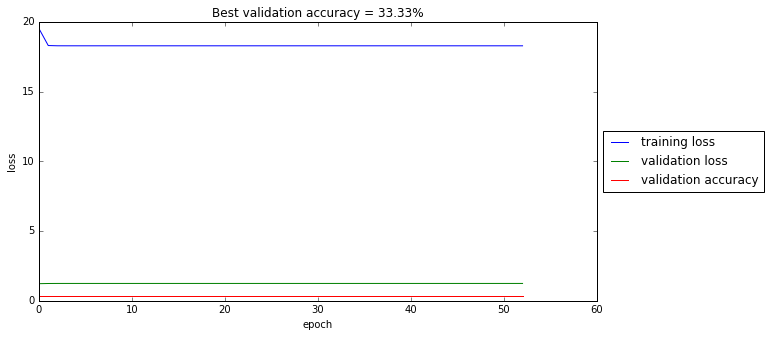

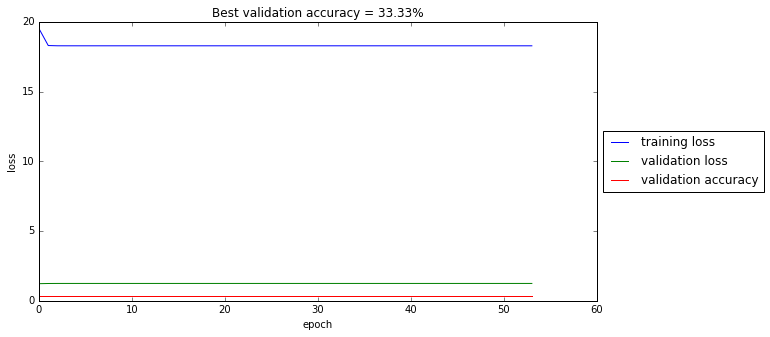

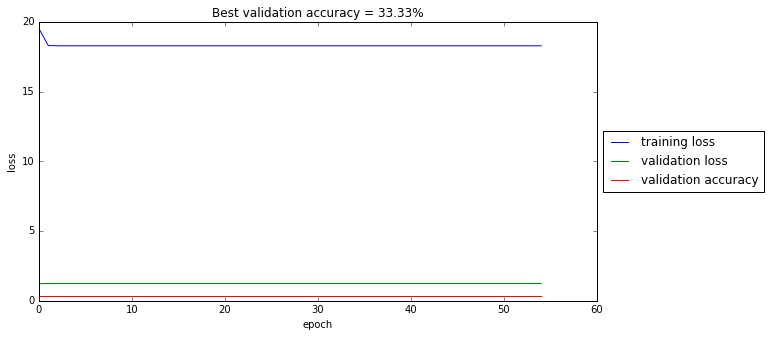

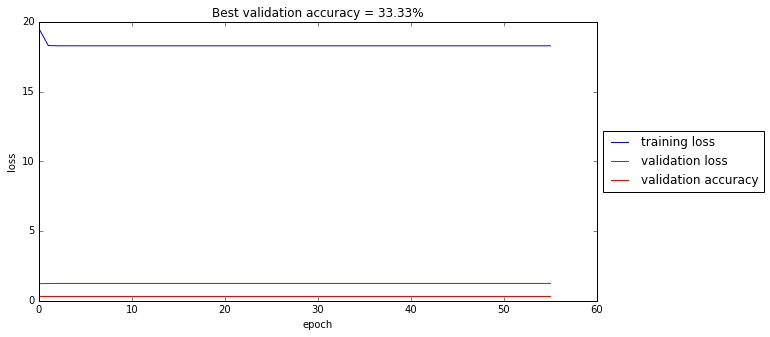

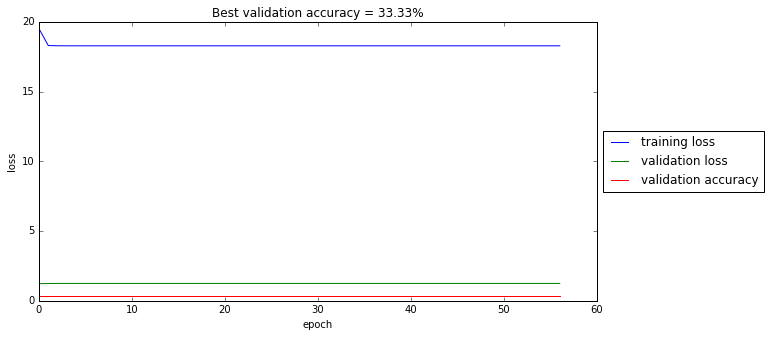

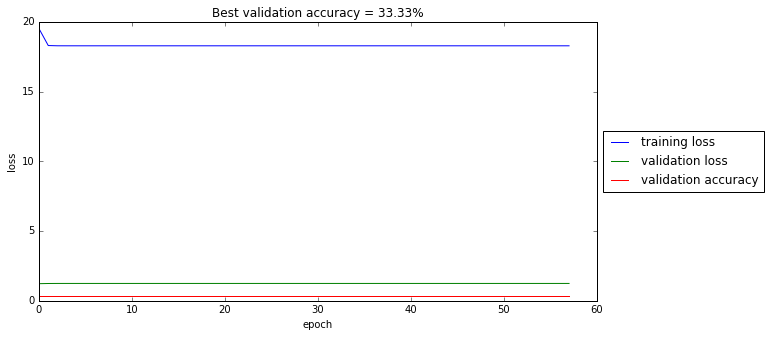

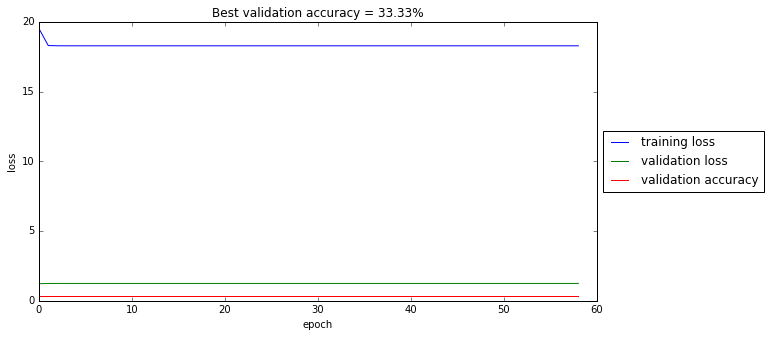

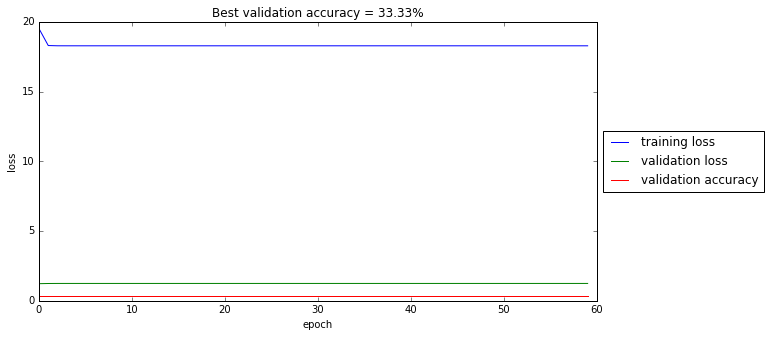

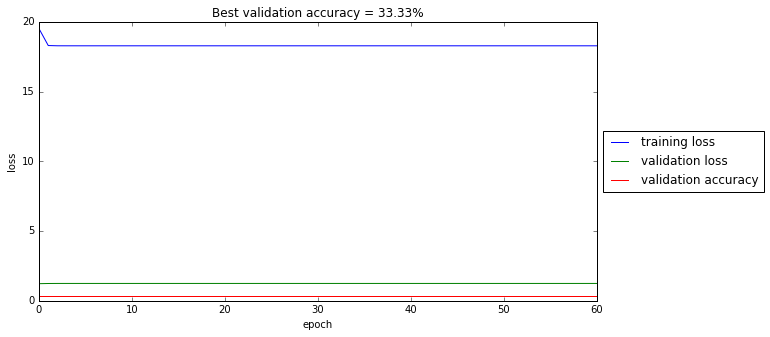

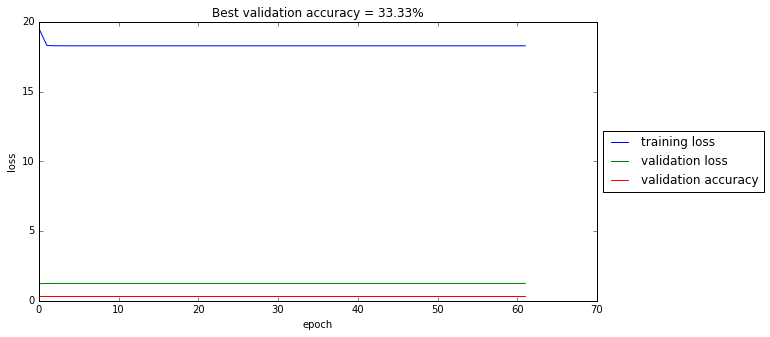

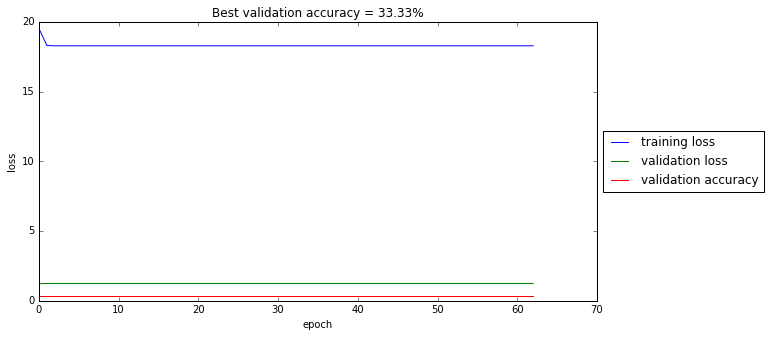

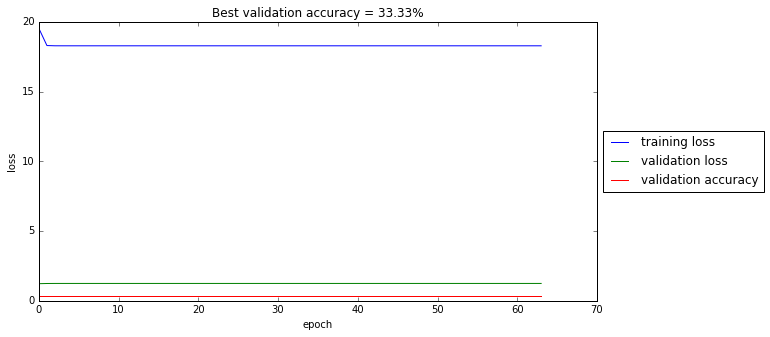

In [87]:
# Task 1
# learning algorithm
n_epochs   = 200
batch_size = 64 # adapt this value based on the memory of your GPU
n_mini_batch_training = x_train.shape[0]/batch_size # number of training mini-batches given the batch_size

# lists where we will be storing values during training, for visualization purposes
tra_losses = []
val_losses = []
val_accs   = []

# we want to save the parameters that give the best performance on the validation set
# therefore, we store the best validation accuracy, and save the parameters to disk
best_val_acc = 0

# loop over the number of epochs
for epoch in xrange(n_epochs):
    
    st = time.time()
    
    # training
    cum_tra_loss = 0.0 # cumulative training loss
    for b in range(n_mini_batch_training):
        x_batch = x_train[b*batch_size:batch_size*(b+1)].astype(np.float32) # extract a mini-batch from x_train
        y_batch = y_train[b*batch_size:batch_size*(b+1)].astype(np.float32) # extract labels for the mini-batch
        mini_batch_loss = train_fn(x_batch, y_batch)
        cum_tra_loss += mini_batch_loss
        
    # validation
    val_loss, val_acc = val_fn(x_validation.astype(np.float32), y_validation.astype(np.float32))
    # if the accuracy improves, save the network parameters
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # save network
        params = lasagne.layers.get_all_param_values(network)
        np.savez('./nn_params.npz', params=params)
    
    tra_loss = cum_tra_loss # final training loss for this epoch
    
    # add to lists
    tra_losses.append(tra_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    en = time.time()

    # plot learning curves
    fig = plt.figure(figsize=(10, 5))
    tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
    val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
    val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend([tra_loss_plt, val_loss_plt, val_acc_plt], 
               ['training loss', 'validation loss', 'validation accuracy'],
               loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_val_acc))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.2)